In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, GRU, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.layers import Dropout

In [ ]:
df1 = pd.read_csv('df.csv') 

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1['theft'] = le.fit_transform(df1['theft']) 

In [ ]:
df1['Class'] = le.fit_transform(df1['Class']) 

In [ ]:
df_0 = df1[df1['theft']==0]
df_1 = df1[df1['theft']==1]
df_2 = df1[df1['theft']==2]
df_3 = df1[df1['theft']==3]
df_4 = df1[df1['theft']==4]
df_5 = df1[df1['theft']==5]
df_6 = df1[df1['theft']==6]

In [ ]:
df_0_sampled = df_0.sample(51083)
df_1_sampled = df_1.sample(51083,replace=True)
df_2_sampled = df_2.sample(51083,replace=True)
df_3_sampled = df_3.sample(51083,replace=True)
df_4_sampled = df_4.sample(51083,replace=True)
df_5_sampled = df_5.sample(51083,replace=True)
df_6_sampled = df_6.sample(51083,replace=True)


In [ ]:
df_balanced = pd.concat([df_0_sampled,df_1_sampled,df_2_sampled,df_3_sampled,df_4_sampled,df_5_sampled,df_6_sampled])
df_balanced

In [ ]:
X1=df_balanced.drop(["0","theft"],axis=1)
y1=df_balanced.pop("theft")

### Feature Importance 1

                                        Specs         Score
0           Electricity:Facility [kW](Hourly)  1.598279e+07
6                   Gas:Facility [kW](Hourly)  7.506874e+06
7                    Heating:Gas [kW](Hourly)  5.179440e+06
2            Cooling:Electricity [kW](Hourly)  4.517504e+06
5  InteriorEquipment:Electricity [kW](Hourly)  4.133756e+06


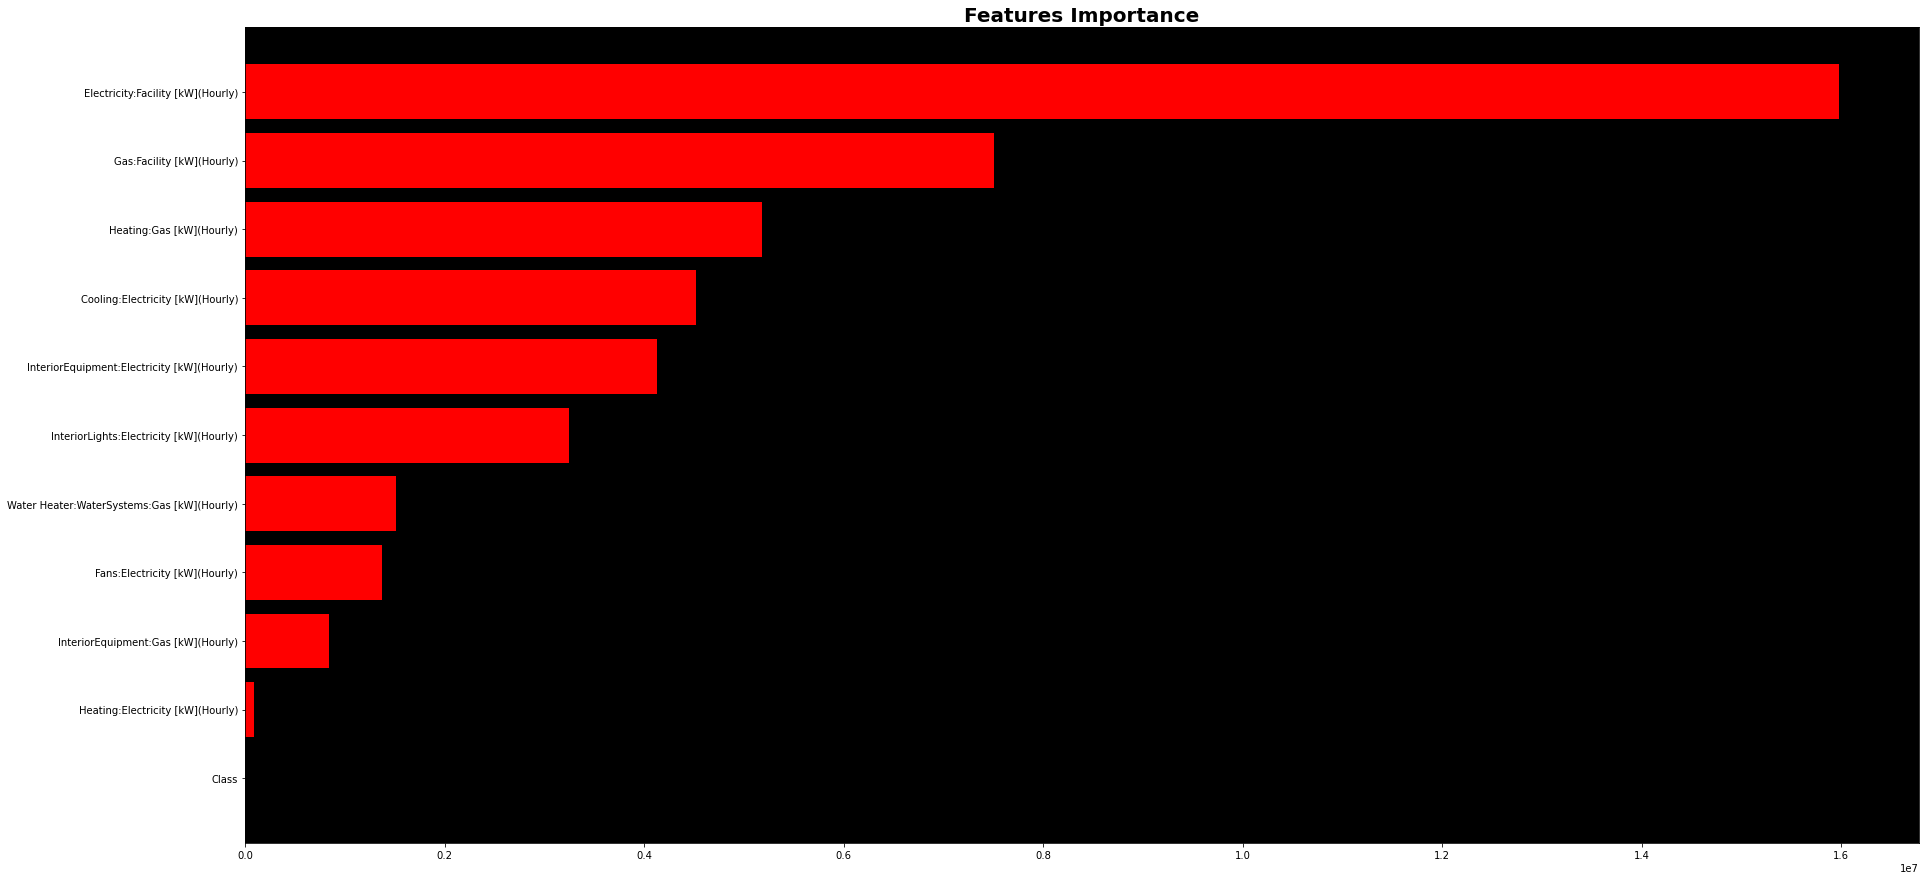

In [77]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features
featureScores.sort_values('Score',inplace=True)
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
ax = plt.axes()
ax.set_facecolor("black")
plt.title("Features Importance", fontweight='bold',fontsize=20)
plt.barh(featureScores["Specs"],featureScores["Score"],color='r')
plt.show()

### Feature Importance 2

In [80]:
rf = RandomForestRegressor(n_estimators=13,random_state=42)
rf.fit(X1, y1)

# Calculate feature importances
importances = rf.feature_importances_

# Sort the features by importance in descending order
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature Electricity:Facility [kW](Hourly) (0.17918367779696978)
2. feature Fans:Electricity [kW](Hourly) (0.16615270546281505)
3. feature Water Heater:WaterSystems:Gas [kW](Hourly) (0.13438120009775717)
4. feature Gas:Facility [kW](Hourly) (0.10303143871399872)
5. feature Cooling:Electricity [kW](Hourly) (0.09426925115930797)
6. feature InteriorLights:Electricity [kW](Hourly) (0.08320724701132735)
7. feature InteriorEquipment:Electricity [kW](Hourly) (0.08168347033566495)
8. feature Heating:Gas [kW](Hourly) (0.06776459442334314)
9. feature InteriorEquipment:Gas [kW](Hourly) (0.05574877956975178)
10. feature Class (0.017790905917684317)
11. feature Heating:Electricity [kW](Hourly) (0.01678672951137991)


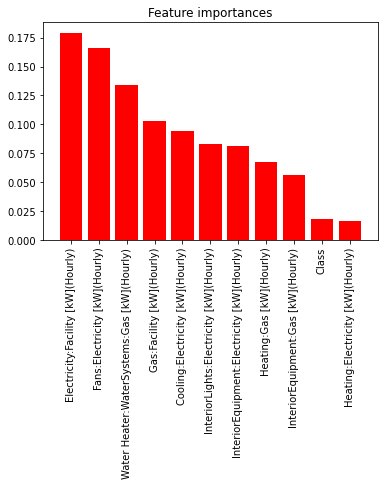

In [81]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [19]:
imp_fea1 = pd.DataFrame(df_balanced.drop(["0","Class","Fans:Electricity [kW](Hourly)","Heating:Electricity [kW](Hourly)","InteriorLights:Electricity [kW](Hourly)","Water Heater:WaterSystems:Gas [kW](Hourly)","InteriorEquipment:Gas [kW](Hourly)"],axis=1))

In [20]:
imp_fea2 = pd.DataFrame(df_balanced.drop(["0","Class","Heating:Electricity [kW](Hourly)","InteriorEquipment:Gas [kW](Hourly)","Heating:Gas [kW](Hourly)","InteriorEquipment:Electricity [kW](Hourly)","InteriorLights:Electricity [kW](Hourly)"],axis=1))

In [21]:
imp_fea1.columns

Index(['Electricity:Facility [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)', 'theft'],
      dtype='object')

In [22]:
imp_fea2.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'theft'],
      dtype='object')

### Model building

### Feature Importance 1

In [23]:
X=imp_fea1.drop(["theft"],axis=1)
y=imp_fea1.pop("theft")

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X_normalized, y, test_size=0.20, random_state=42)
x_train_array=np.asarray(x_train)
x_train_t = x_train_array.reshape(-1, x_train_array.shape[1], 1)
x_test_array=np.asarray(x_test)
x_test_t = x_test_array.reshape(-1, x_test_array.shape[1], 1)
y_train_array=np.asarray(y_train)
y_test_array=np.asarray(y_test)
train_labels = keras.utils.to_categorical(y_train_array)
test_labels = keras.utils.to_categorical(y_test_array)
n_timesteps, n_features = x_train.shape
print("n_timesteps",n_timesteps)

n_timesteps 286064


In [109]:

model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add the GRU layers
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=70, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/70
4470/4470 [==============================] - 44s 9ms/step - loss: 1.4818 - accuracy: 0.3538 - val_loss: 1.4299 - val_accuracy: 0.3908
Epoch 2/70
4470/4470 [==============================] - 39s 9ms/step - loss: 1.3841 - accuracy: 0.4135 - val_loss: 1.5268 - val_accuracy: 0.3918
Epoch 3/70
4470/4470 [==============================] - 38s 9ms/step - loss: 1.3018 - accuracy: 0.4491 - val_loss: 1.2460 - val_accuracy: 0.4693
Epoch 4/70
4470/4470 [==============================] - 37s 8ms/step - loss: 1.2089 - accuracy: 0.4887 - val_loss: 1.1761 - val_accuracy: 0.4988
Epoch 5/70
4470/4470 [==============================] - 37s 8ms/step - loss: 1.1470 - accuracy: 0.5125 - val_loss: 1.1338 - val_accuracy: 0.5190
Epoch 6/70
4470/4470 [==============================] - 38s 8ms/step - loss: 1.0960 - accuracy: 0.5343 - val_loss: 1.1057 - val_accuracy: 0.5295
Epoch 7/70
4470/4470 [==============================] - 38s 9ms/step - loss: 1.0632 - accuracy: 0.5475 - val_loss: 1.0359 - val_ac

In [111]:
y_predict=model.predict(x_test_t)

2235/2235 [==============================] - 8s 3ms/step


In [112]:
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)


In [114]:
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)

In [115]:
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)

In [116]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)

[[ 8113   181     0   206   130   265  1397]
 [  339  4496     0  3019  1687   319   386]
 [    0     0 10167     0     0     0     0]
 [  357  3322     0  4109  1798   434   322]
 [  194   602    11   655  8268   218   190]
 [  122    50     0   119    61  9569   122]
 [ 4940   795     1   854  1023   889  1787]]


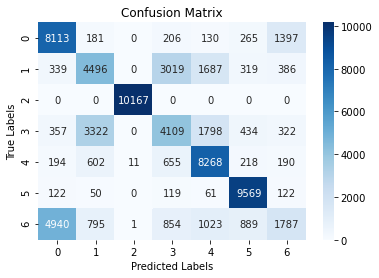

In [118]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()

In [119]:
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))


              precision    recall  f1-score   support

           0       0.58      0.79      0.67     10292
           1       0.48      0.44      0.46     10246
           2       1.00      1.00      1.00     10167
           3       0.46      0.40      0.43     10342
           4       0.64      0.82      0.72     10138
           5       0.82      0.95      0.88     10043
           6       0.43      0.17      0.25     10289

    accuracy                           0.65     71517
   macro avg       0.63      0.65      0.63     71517
weighted avg       0.63      0.65      0.63     71517



### Using Feature Importance2

In [124]:
X2=imp_fea2.drop(["theft"],axis=1)
y2=imp_fea2.pop("theft")

In [125]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X2)

In [126]:
x_train,x_test,y_train,y_test=train_test_split(X_normalized, y2, test_size=0.20, random_state=42)
x_train_array=np.asarray(x_train)
x_train_t = x_train_array.reshape(-1, x_train_array.shape[1], 1)
x_test_array=np.asarray(x_test)
x_test_t = x_test_array.reshape(-1, x_test_array.shape[1], 1)
y_train_array=np.asarray(y_train)
y_test_array=np.asarray(y_test)
train_labels = keras.utils.to_categorical(y_train_array)
test_labels = keras.utils.to_categorical(y_test_array)
n_timesteps, n_features = x_train.shape
print("n_timesteps",n_timesteps)

n_timesteps 286064


In [127]:

model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add the GRU layers
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=70, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/70
4470/4470 [==============================] - 83s 17ms/step - loss: 1.4515 - accuracy: 0.3751 - val_loss: 1.3527 - val_accuracy: 0.4154
Epoch 2/70
4470/4470 [==============================] - 78s 17ms/step - loss: 1.2996 - accuracy: 0.4514 - val_loss: 1.2563 - val_accuracy: 0.4706
Epoch 3/70
4470/4470 [==============================] - 49s 11ms/step - loss: 1.2174 - accuracy: 0.4901 - val_loss: 1.1816 - val_accuracy: 0.5025
Epoch 4/70
4470/4470 [==============================] - 48s 11ms/step - loss: 1.1521 - accuracy: 0.5149 - val_loss: 1.1387 - val_accuracy: 0.5159
Epoch 5/70
4470/4470 [==============================] - 49s 11ms/step - loss: 1.1097 - accuracy: 0.5301 - val_loss: 1.0788 - val_accuracy: 0.5413
Epoch 6/70
4470/4470 [==============================] - 49s 11ms/step - loss: 1.0755 - accuracy: 0.5442 - val_loss: 1.0593 - val_accuracy: 0.5480
Epoch 7/70
4470/4470 [==============================] - 52s 12ms/step - loss: 1.0430 - accuracy: 0.5565 - val_loss: 1.0254 -

Epoch 57/70
4470/4470 [==============================] - 51s 11ms/step - loss: 0.7232 - accuracy: 0.6768 - val_loss: 0.7682 - val_accuracy: 0.6547
Epoch 58/70
4470/4470 [==============================] - 52s 12ms/step - loss: 0.7215 - accuracy: 0.6772 - val_loss: 0.7715 - val_accuracy: 0.6567
Epoch 59/70
4470/4470 [==============================] - 51s 11ms/step - loss: 0.7180 - accuracy: 0.6792 - val_loss: 0.7748 - val_accuracy: 0.6518
Epoch 60/70
4470/4470 [==============================] - 52s 12ms/step - loss: 0.7171 - accuracy: 0.6784 - val_loss: 0.7733 - val_accuracy: 0.6550
Epoch 61/70
4470/4470 [==============================] - 52s 12ms/step - loss: 0.7140 - accuracy: 0.6804 - val_loss: 0.7799 - val_accuracy: 0.6512
Epoch 62/70
4470/4470 [==============================] - 62s 14ms/step - loss: 0.7133 - accuracy: 0.6803 - val_loss: 0.7517 - val_accuracy: 0.6634
Epoch 63/70
4470/4470 [==============================] - 62s 14ms/step - loss: 0.7124 - accuracy: 0.6815 - val_loss: 0

In [128]:
y_predict=model.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 10s 4ms/step


[[ 7075   186     0   182    67   376  2406]
 [  283  4264     0  3581  1353   328   437]
 [    0     0 10167     0     0     0     0]
 [  299  2881     0  4874  1454   430   404]
 [   50   588     0   619  8495   129   257]
 [   62    62     0   133    61  9487   238]
 [ 4059   680     0   849   954   894  2853]]


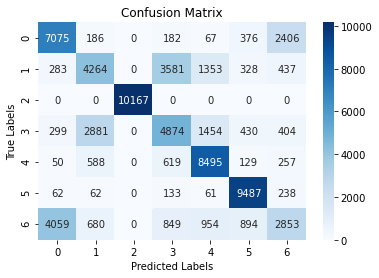

              precision    recall  f1-score   support

           0       0.60      0.69      0.64     10292
           1       0.49      0.42      0.45     10246
           2       1.00      1.00      1.00     10167
           3       0.48      0.47      0.47     10342
           4       0.69      0.84      0.75     10138
           5       0.81      0.94      0.87     10043
           6       0.43      0.28      0.34     10289

    accuracy                           0.66     71517
   macro avg       0.64      0.66      0.65     71517
weighted avg       0.64      0.66      0.65     71517



In [129]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))


### Imp fea 3

In [ ]:
imp_fea3 = pd.DataFrame(df_balanced.drop(["0","Class","Heating:Electricity [kW](Hourly)"],axis=1))

In [ ]:
X3=imp_fea3.drop(["theft"],axis=1)
y3=imp_fea3.pop("theft")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X3)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X_normalized, y3, test_size=0.20, random_state=42)
x_train_array=np.asarray(x_train)
x_train_t = x_train_array.reshape(-1, x_train_array.shape[1], 1)
x_test_array=np.asarray(x_test)
x_test_t = x_test_array.reshape(-1, x_test_array.shape[1], 1)
y_train_array=np.asarray(y_train)
y_test_array=np.asarray(y_test)
train_labels = keras.utils.to_categorical(y_train_array)
test_labels = keras.utils.to_categorical(y_test_array)
n_timesteps, n_features = x_train.shape
print("n_timesteps",n_timesteps)

In [138]:

model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add the GRU layers
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
4470/4470 [==============================] - 405s 89ms/step - loss: 1.3981 - accuracy: 0.4170 - val_loss: 1.1113 - val_accuracy: 0.5366
Epoch 2/75
4470/4470 [==============================] - 395s 88ms/step - loss: 0.9440 - accuracy: 0.5910 - val_loss: 0.8330 - val_accuracy: 0.6238
Epoch 3/75
4470/4470 [==============================] - 408s 91ms/step - loss: 0.8204 - accuracy: 0.6318 - val_loss: 0.7788 - val_accuracy: 0.6341
Epoch 4/75
4470/4470 [==============================] - 722s 162ms/step - loss: 0.7671 - accuracy: 0.6484 - val_loss: 0.9423 - val_accuracy: 0.6102
Epoch 5/75
4470/4470 [==============================] - 305s 68ms/step - loss: 0.7513 - accuracy: 0.6526 - val_loss: 0.7198 - val_accuracy: 0.6588
Epoch 6/75
4470/4470 [==============================] - 306s 69ms/step - loss: 0.7283 - accuracy: 0.6614 - val_loss: 0.7790 - val_accuracy: 0.6420
Epoch 7/75
4470/4470 [==============================] - 306s 68ms/step - loss: 0.6984 - accuracy: 0.6709 - val_loss: 

In [139]:
y_predict=model.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 25s 10ms/step


[[ 8798    30     0    19     4    39  1402]
 [   50  6353     0  3232   299    32   280]
 [    0     0 10167     0     0     0     0]
 [   33  4591     0  5102   327    38   251]
 [    8   409     8   372  9186    12   143]
 [   39    47     0    65     8  9722   162]
 [ 5288   908     0   733   753   684  1923]]


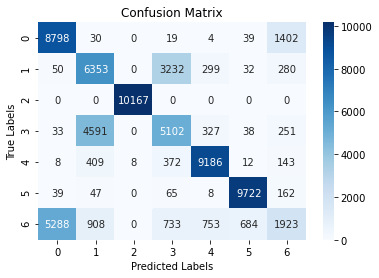

              precision    recall  f1-score   support

           0       0.62      0.85      0.72     10292
           1       0.51      0.62      0.56     10246
           2       1.00      1.00      1.00     10167
           3       0.54      0.49      0.51     10342
           4       0.87      0.91      0.89     10138
           5       0.92      0.97      0.95     10043
           6       0.46      0.19      0.27     10289

    accuracy                           0.72     71517
   macro avg       0.70      0.72      0.70     71517
weighted avg       0.70      0.72      0.70     71517



In [141]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
  

### Batch size32

In [142]:
model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add the GRU layers
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=32, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
8940/8940 [==============================] - 625s 69ms/step - loss: 1.2718 - accuracy: 0.4695 - val_loss: 0.9659 - val_accuracy: 0.5791
Epoch 2/75
8940/8940 [==============================] - 4572s 511ms/step - loss: 0.8951 - accuracy: 0.6078 - val_loss: 0.8115 - val_accuracy: 0.6304
Epoch 3/75
8940/8940 [==============================] - 617s 69ms/step - loss: 0.8017 - accuracy: 0.6358 - val_loss: 0.8281 - val_accuracy: 0.6209
Epoch 4/75
8940/8940 [==============================] - 616s 69ms/step - loss: 0.7678 - accuracy: 0.6455 - val_loss: 0.7314 - val_accuracy: 0.6603
Epoch 5/75
8940/8940 [==============================] - 610s 68ms/step - loss: 0.7285 - accuracy: 0.6580 - val_loss: 0.7558 - val_accuracy: 0.6497
Epoch 6/75
8940/8940 [==============================] - 612s 68ms/step - loss: 0.7101 - accuracy: 0.6657 - val_loss: 0.7133 - val_accuracy: 0.6622
Epoch 7/75
8940/8940 [==============================] - 5018s 561ms/step - loss: 0.6924 - accuracy: 0.6711 - val_los

In [143]:
y_predict=model.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 45s 20ms/step


[[ 8165    25     0    53    14    99  1936]
 [   34  5069     0  4438   378    59   268]
 [    0     0 10167     0     0     0     0]
 [   34  3635     2  5993   404    72   202]
 [    4   139     7   204  9678    12    94]
 [   74     5     0     8     5  9870    81]
 [ 4886   736     0   958   838   800  2071]]


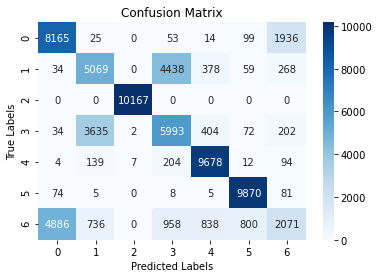

              precision    recall  f1-score   support

           0       0.62      0.79      0.70     10292
           1       0.53      0.49      0.51     10246
           2       1.00      1.00      1.00     10167
           3       0.51      0.58      0.54     10342
           4       0.86      0.95      0.90     10138
           5       0.90      0.98      0.94     10043
           6       0.45      0.20      0.28     10289

    accuracy                           0.71     71517
   macro avg       0.69      0.72      0.70     71517
weighted avg       0.69      0.71      0.69     71517



In [144]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

In [146]:
import tensorflow as tf

# Save the entire model
model.save('model32feat3')

# Save only the model weights
model.save_weights('model32feat3.h5')

INFO:tensorflow:Assets written to: model32feat3\assets


INFO:tensorflow:Assets written to: model32feat3\assets


In [148]:

# Load the entire model
model1 = tf.keras.models.load_model('model32feat3')

# Load only the model weights
model.load_weights('model32feat3.h5')

In [149]:
model1.predict(x_test_t)

2235/2235 [==============================] - 110s 49ms/step


array([[6.1855006e-01, 1.3929777e-04, 1.6571614e-11, ..., 4.1511760e-07,
        2.8703205e-05, 3.8091251e-01],
       [1.6614006e-04, 3.3241168e-01, 2.6258118e-10, ..., 2.0977765e-01,
        1.6471553e-04, 2.7490658e-01],
       [8.8469627e-05, 2.5692855e-03, 7.7657099e-08, ..., 2.1646998e-04,
        9.9436176e-01, 1.8618500e-04],
       ...,
       [2.7726185e-12, 3.4208893e-11, 1.0000000e+00, ..., 5.1961919e-08,
        3.7313429e-12, 3.4409808e-10],
       [2.7726185e-12, 3.4208893e-11, 1.0000000e+00, ..., 5.1961919e-08,
        3.7313429e-12, 3.4409808e-10],
       [5.2509069e-01, 8.6790184e-04, 2.2814829e-14, ..., 7.8715576e-04,
        2.7450901e-06, 4.7198373e-01]], dtype=float32)

### Different structure #32bs 

In [15]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',  input_shape=(x_train_t.shape[1], 1)))
model.add(GRU(64,return_sequences=True))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GRU(128, return_sequences=True))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(GRU(256, return_sequences=False))
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=32, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
8940/8940 [==============================] - 206s 23ms/step - loss: 1.2467 - accuracy: 0.4823 - val_loss: 0.8787 - val_accuracy: 0.6151
Epoch 2/75
8940/8940 [==============================] - 206s 23ms/step - loss: 0.8338 - accuracy: 0.6244 - val_loss: 0.8004 - val_accuracy: 0.6341
Epoch 3/75
8940/8940 [==============================] - 183s 20ms/step - loss: 0.7630 - accuracy: 0.6494 - val_loss: 0.7393 - val_accuracy: 0.6584
Epoch 4/75
8940/8940 [==============================] - 182s 20ms/step - loss: 0.7209 - accuracy: 0.6643 - val_loss: 0.7267 - val_accuracy: 0.6596
Epoch 5/75
8940/8940 [==============================] - 191s 21ms/step - loss: 0.6940 - accuracy: 0.6745 - val_loss: 0.7064 - val_accuracy: 0.6675
Epoch 6/75
8940/8940 [==============================] - 197s 22ms/step - loss: 0.6771 - accuracy: 0.6793 - val_loss: 0.6720 - val_accuracy: 0.6720
Epoch 7/75
8940/8940 [==============================] - 196s 22ms/step - loss: 0.6617 - accuracy: 0.6864 - val_loss: 0

In [19]:
import tensorflow as tf

# Save the entire model
model.save('model2_32')

# Save only the model weights
model.save_weights('model2_32.h5')

INFO:tensorflow:Assets written to: model2_32\assets


INFO:tensorflow:Assets written to: model2_32\assets


In [21]:
# Load the entire model
model2 = tf.keras.models.load_model('model2_32')

# Load only the model weights
model2.load_weights('model2_32.h5')

In [24]:
y_predict=model2.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 34s 15ms/step


[[ 8881    30     0    31    11   144  1195]
 [   89  4720     0  4589   475   106   267]
 [    0     0 10167     0     0     0     0]
 [  103  3347     2  6045   489    96   260]
 [    9   193     3   195  9500    41   197]
 [  118     9     0    18    12  9816    70]
 [ 5626   715     0   935   791   790  1432]]


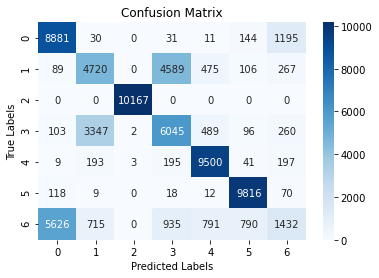

              precision    recall  f1-score   support

           0       0.60      0.86      0.71     10292
           1       0.52      0.46      0.49     10246
           2       1.00      1.00      1.00     10167
           3       0.51      0.58      0.55     10342
           4       0.84      0.94      0.89     10138
           5       0.89      0.98      0.93     10043
           6       0.42      0.14      0.21     10289

    accuracy                           0.71     71517
   macro avg       0.68      0.71      0.68     71517
weighted avg       0.68      0.71      0.68     71517



In [25]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

### model2 64

In [26]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',  input_shape=(x_train_t.shape[1], 1)))
model.add(GRU(64,return_sequences=True))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GRU(128, return_sequences=True))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(GRU(256, return_sequences=False))
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
4470/4470 [==============================] - 366s 81ms/step - loss: 1.3390 - accuracy: 0.4533 - val_loss: 0.9833 - val_accuracy: 0.5833
Epoch 2/75
4470/4470 [==============================] - 343s 77ms/step - loss: 0.8588 - accuracy: 0.6198 - val_loss: 0.8531 - val_accuracy: 0.6178
Epoch 3/75
4470/4470 [==============================] - 344s 77ms/step - loss: 0.7541 - accuracy: 0.6533 - val_loss: 0.7191 - val_accuracy: 0.6596
Epoch 4/75
4470/4470 [==============================] - 347s 78ms/step - loss: 0.7074 - accuracy: 0.6699 - val_loss: 0.6860 - val_accuracy: 0.6753
Epoch 5/75
4470/4470 [==============================] - 364s 81ms/step - loss: 0.6757 - accuracy: 0.6810 - val_loss: 0.6976 - val_accuracy: 0.6637
Epoch 6/75
4470/4470 [==============================] - 367s 82ms/step - loss: 0.6545 - accuracy: 0.6877 - val_loss: 0.6659 - val_accuracy: 0.6861
Epoch 7/75
4470/4470 [==============================] - 362s 81ms/step - loss: 0.6402 - accuracy: 0.6954 - val_loss: 0

In [27]:
import tensorflow as tf

# Save the entire model
model.save('model2_64')

# Save only the model weights
model.save_weights('model2_64.h5')

INFO:tensorflow:Assets written to: model2_64\assets


INFO:tensorflow:Assets written to: model2_64\assets


In [28]:
# Load the entire model
model3 = tf.keras.models.load_model('model2_64')

# Load only the model weights
model3.load_weights('model2_64.h5')

In [29]:
y_predict=model3.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 124s 55ms/step


[[ 8740    29     0    36     7   108  1372]
 [   78  6156     0  3334   283    50   345]
 [    0     0 10167     0     0     0     0]
 [   62  4490     0  5111   322    57   300]
 [   16   208     4   102  9522    24   262]
 [   30    26     0    20     3  9819   145]
 [ 5404   927     0   660   723   709  1866]]


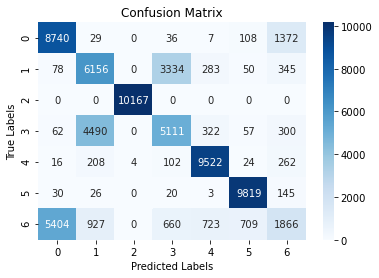

              precision    recall  f1-score   support

           0       0.61      0.85      0.71     10292
           1       0.52      0.60      0.56     10246
           2       1.00      1.00      1.00     10167
           3       0.55      0.49      0.52     10342
           4       0.88      0.94      0.91     10138
           5       0.91      0.98      0.94     10043
           6       0.43      0.18      0.26     10289

    accuracy                           0.72     71517
   macro avg       0.70      0.72      0.70     71517
weighted avg       0.70      0.72      0.70     71517



In [30]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

### model 3 #64


In [37]:

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense

model = Sequential()

# Add convolutional layers with max pooling
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(x_train_t.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

# Add GRU layers
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=32))

# Add dense layer and output layer


model.add(Dense(train_labels.shape[1], activation='softmax'))

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 7, 64)             256       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 conv1d_23 (Conv1D)          (None, 1, 128)            24704     
                                                                 
 gru_14 (GRU)                (None, 1, 64)             37248     
                                                                 
 gru_15 (GRU)                (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                      

Epoch 48/75
4470/4470 [==============================] - 156s 35ms/step - loss: 0.6156 - accuracy: 0.6975 - val_loss: 0.6290 - val_accuracy: 0.6900
Epoch 49/75
4470/4470 [==============================] - 163s 36ms/step - loss: 0.6146 - accuracy: 0.6973 - val_loss: 0.6218 - val_accuracy: 0.6938
Epoch 50/75
4470/4470 [==============================] - 171s 38ms/step - loss: 0.6131 - accuracy: 0.6986 - val_loss: 0.6410 - val_accuracy: 0.6870
Epoch 51/75
4470/4470 [==============================] - 155s 35ms/step - loss: 0.6109 - accuracy: 0.6985 - val_loss: 0.6247 - val_accuracy: 0.6897
Epoch 52/75
4470/4470 [==============================] - 156s 35ms/step - loss: 0.6097 - accuracy: 0.6992 - val_loss: 0.6277 - val_accuracy: 0.6932
Epoch 53/75
4470/4470 [==============================] - 160s 36ms/step - loss: 0.6094 - accuracy: 0.6994 - val_loss: 0.6438 - val_accuracy: 0.6804
Epoch 54/75
4470/4470 [==============================] - 175s 39ms/step - loss: 0.6063 - accuracy: 0.7009 - val_

In [38]:
model.save('model3_64')

# Save only the model weights
model.save_weights('model3_64.h5')

INFO:tensorflow:Assets written to: model3_64\assets


INFO:tensorflow:Assets written to: model3_64\assets


In [40]:
# Load the entire model
model4 = tf.keras.models.load_model('model3_64')

# Load only the model weights
model4.load_weights('model3_64.h5')

In [41]:
y_predict=model4.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)



2235/2235 [==============================] - 28s 12ms/step


[[ 8640    47     0    30    10    89  1476]
 [  108  5663     0  3724   342    66   343]
 [    0     0 10167     0     0     0     0]
 [  124  5150     1  4286   329    54   398]
 [    8   153    11   167  9622    32   145]
 [   78     0     0    10     0  9858    97]
 [ 5473  1009     0   687   803   742  1575]]


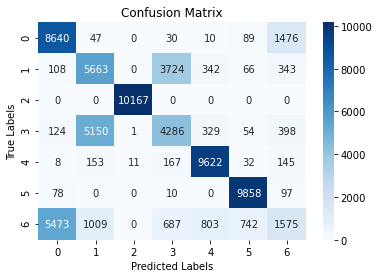

              precision    recall  f1-score   support

           0       0.60      0.84      0.70     10292
           1       0.47      0.55      0.51     10246
           2       1.00      1.00      1.00     10167
           3       0.48      0.41      0.45     10342
           4       0.87      0.95      0.91     10138
           5       0.91      0.98      0.94     10043
           6       0.39      0.15      0.22     10289

    accuracy                           0.70     71517
   macro avg       0.67      0.70      0.67     71517
weighted avg       0.67      0.70      0.67     71517



In [42]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

In [43]:
imp_fea3

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly)
272266,15.415824,0.000000,0.000000,5.481225,1.011600,0.000000,0.000000,0.000000,0.000000
72486,25.324337,1.917358,0.000000,3.711679,18.077000,64.050739,36.118910,21.007700,6.924129
507896,111.838629,0.000000,0.000000,43.513342,52.539744,4.854260,0.000000,4.834260,0.020000
126690,194.484373,40.433273,0.286396,13.974760,18.691965,82.217587,76.382753,4.670000,1.164834
3409,14.802178,0.000000,0.000000,1.529975,7.490200,3.359880,0.000000,3.339880,0.020000
...,...,...,...,...,...,...,...,...,...
228217,72.029560,6.997811,18.852596,18.743377,27.431321,18.045000,0.000000,18.025000,0.020000
56948,61.900752,16.292027,15.961208,2.732531,23.612374,70.015399,66.085761,3.616971,0.312667
369471,58.661057,5.847534,0.408342,18.508201,25.635382,40.381688,34.590727,0.000000,5.790961
158304,127.240414,30.767616,14.762724,25.524085,30.610669,172.495380,60.740273,3.332120,108.422987


In [35]:
def predict(a,b,c,d,e,f,g,h,i):
    test=[[a,b,c,d,e,f,g,h,i]]
    import tensorflow as tf
    test=np.asarray(test)
    test=test.reshape(-1, test.shape[1], 1)
     # Load the entire model
    model1 = tf.keras.models.load_model('model32feat3')
    # Load only the model weights
    model1.load_weights('model32feat3.h5')
    y_predict=model1.predict(test)
    #print(y_predict)
    final=[]
    for i in y_predict:
        max_index=np.argmax(i)
        binary_output=np.zeros_like(i)
        binary_output[max_index]=1
        final.append(binary_output)
        #print(final)
    final_test = []

# iterate over the list and find the index of elements with value 1
    for my_list in final:
        for i in range(len(my_list)):
            if my_list[i] == 1:
                final_test.append(i)
    print(final_test)
    

    for i in range(len(final_test)):
        if final_test[i] == 0:
            print("Consumer belongs to normal type")
        elif final_test[i] == 1:
            print("Consumer belongs to theft 1 type")
        elif final_test[i] == 2:
            print("Consumer belongs to theft 2 type")
        elif final_test[i] == 3:
            print("Consumer belongs to theft 3 type")
        elif final_test[i] == 4:
            print("Consumer belongs to theft 4 type")
        elif final_test[i] == 5:
            print("Consumer belongs to theft 5 type")
        elif final_test[i] == 6:
            print("Consumer belongs to theft 6 type")

In [151]:
predict(15.415824 ,0.000000 ,0.000000 ,5.481225 ,1.011600 ,0.000000 ,0.000000 ,0.000000 ,0.000000)

1/1 [==============================] - 1s 1s/step
[0]
Consumer belongs to normal type


In [152]:
predict(58.661057,16.292027 ,15.961208 ,2.732531 ,23.612374 ,70.015399 ,66.085761 ,3.616971 ,0.312667)

1/1 [==============================] - 1s 873ms/step
[6]
Consumer belongs to theft 6 type


### F1-M2-64


In [28]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',  input_shape=(x_train_t.shape[1], 1)))
model.add(GRU(64,return_sequences=True))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GRU(128, return_sequences=True))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(GRU(256, return_sequences=False))
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
history=model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
4470/4470 [==============================] - 59s 12ms/step - loss: 1.4586 - accuracy: 0.3704 - val_loss: 1.3791 - val_accuracy: 0.4144
Epoch 2/75
4470/4470 [==============================] - 51s 11ms/step - loss: 1.3481 - accuracy: 0.4270 - val_loss: 1.3189 - val_accuracy: 0.4423
Epoch 3/75
4470/4470 [==============================] - 49s 11ms/step - loss: 1.2963 - accuracy: 0.4478 - val_loss: 1.2628 - val_accuracy: 0.4615
Epoch 4/75
4470/4470 [==============================] - 49s 11ms/step - loss: 1.2325 - accuracy: 0.4763 - val_loss: 1.1959 - val_accuracy: 0.4918
Epoch 5/75
4470/4470 [==============================] - 49s 11ms/step - loss: 1.1644 - accuracy: 0.5063 - val_loss: 1.1389 - val_accuracy: 0.5135
Epoch 6/75
4470/4470 [==============================] - 48s 11ms/step - loss: 1.1128 - accuracy: 0.5274 - val_loss: 1.0897 - val_accuracy: 0.5341
Epoch 7/75
4470/4470 [==============================] - 48s 11ms/step - loss: 1.0586 - accuracy: 0.5489 - val_loss: 1.0631 -

In [29]:
model.save('model-F1-M2-64')

# Save only the model weights
model.save_weights('model-F1-M2-64')

INFO:tensorflow:Assets written to: model-F1-M2-64\assets


INFO:tensorflow:Assets written to: model-F1-M2-64\assets


In [31]:
import tensorflow as tf

In [32]:
# Load the entire model
model5 = tf.keras.models.load_model('model-F1-M2-64')

# Load only the model weights
model5.load_weights('model-F1-M2-64')

In [34]:
y_predict=model5.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)

2235/2235 [==============================] - 14s 6ms/step


[[ 7251   270     0   219   226   320  2006]
 [  239  4674     0  2784  1888   311   350]
 [    0     0 10167     0     0     0     0]
 [  247  3410     0  3979  1986   374   346]
 [  105   530     1   415  8860    97   130]
 [   87   111     0    57   264  9431    93]
 [ 4348   900     0   713  1188   932  2208]]


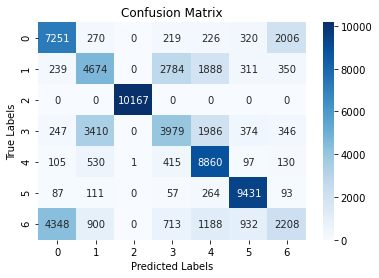

              precision    recall  f1-score   support

           0       0.59      0.70      0.64     10292
           1       0.47      0.46      0.46     10246
           2       1.00      1.00      1.00     10167
           3       0.49      0.38      0.43     10342
           4       0.61      0.87      0.72     10138
           5       0.82      0.94      0.88     10043
           6       0.43      0.21      0.29     10289

    accuracy                           0.65     71517
   macro avg       0.63      0.65      0.63     71517
weighted avg       0.63      0.65      0.63     71517



In [36]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

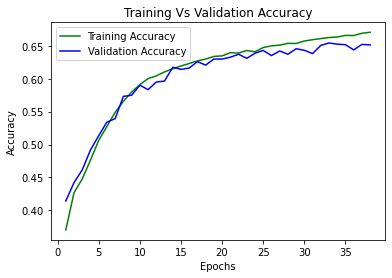

In [43]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,39)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
    

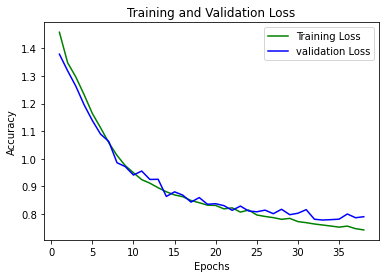

In [45]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,39)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### F3-M1-64

In [47]:
model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
#model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))


# Add the GRU layers
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
history=model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Epoch 1/75
4470/4470 [==============================] - 61s 12ms/step - loss: 1.4273 - accuracy: 0.3868 - val_loss: 1.2756 - val_accuracy: 0.4683
Epoch 2/75
4470/4470 [==============================] - 58s 13ms/step - loss: 1.1737 - accuracy: 0.5111 - val_loss: 1.0728 - val_accuracy: 0.5453
Epoch 3/75
4470/4470 [==============================] - 59s 13ms/step - loss: 1.0412 - accuracy: 0.5594 - val_loss: 0.9927 - val_accuracy: 0.5765
Epoch 4/75
4470/4470 [==============================] - 58s 13ms/step - loss: 0.9691 - accuracy: 0.5829 - val_loss: 0.9238 - val_accuracy: 0.5951
Epoch 5/75
4470/4470 [==============================] - 57s 13ms/step - loss: 0.8996 - accuracy: 0.6061 - val_loss: 0.8679 - val_accuracy: 0.6191
Epoch 6/75
4470/4470 [==============================] - 59s 13ms/step - loss: 0.8586 - accuracy: 0.6201 - val_loss: 0.8490 - val_accuracy: 0.6217
Epoch 7/75
4470/4470 [==============================] - 62s 14ms/step - loss: 0.8209 - accuracy: 0.6311 - val_loss: 0.8446 -

Epoch 57/75
4470/4470 [==============================] - 77s 17ms/step - loss: 0.5818 - accuracy: 0.7084 - val_loss: 0.5934 - val_accuracy: 0.7023
Epoch 58/75
4470/4470 [==============================] - 77s 17ms/step - loss: 0.5823 - accuracy: 0.7080 - val_loss: 0.5838 - val_accuracy: 0.7047
Epoch 59/75
4470/4470 [==============================] - 80s 18ms/step - loss: 0.5795 - accuracy: 0.7093 - val_loss: 0.5985 - val_accuracy: 0.6981
Epoch 60/75
4470/4470 [==============================] - 81s 18ms/step - loss: 0.5802 - accuracy: 0.7084 - val_loss: 0.5873 - val_accuracy: 0.7019
Epoch 61/75
4470/4470 [==============================] - 88s 20ms/step - loss: 0.5790 - accuracy: 0.7093 - val_loss: 0.5835 - val_accuracy: 0.7061
Epoch 62/75
4470/4470 [==============================] - 91s 20ms/step - loss: 0.5795 - accuracy: 0.7099 - val_loss: 0.5865 - val_accuracy: 0.7029
Epoch 63/75
4470/4470 [==============================] - 93s 21ms/step - loss: 0.5781 - accuracy: 0.7099 - val_loss: 0

In [49]:
model.save('model-F3-M1-64')

# Save only the model weights
model.save_weights('model-F3-M1-64')

INFO:tensorflow:Assets written to: model-F3-M1-64\assets


INFO:tensorflow:Assets written to: model-F3-M1-64\assets


In [50]:
y_predict=model5.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)

2235/2235 [==============================] - 90s 40ms/step


[[ 1727  1010    36  2867    48     1  4603]
 [  921  1064   101  4335   151     1  3673]
 [    0     0     0 10167     0     0     0]
 [  942  1018   113  4376   201     0  3692]
 [  522  1243     3  5361   260     2  2747]
 [ 1469   628     5  3131     3     0  4807]
 [ 1550   971    44  3359    95     0  4270]]


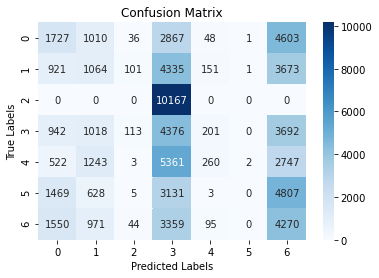

              precision    recall  f1-score   support

           0       0.24      0.17      0.20     10292
           1       0.18      0.10      0.13     10246
           2       0.00      0.00      0.00     10167
           3       0.13      0.42      0.20     10342
           4       0.34      0.03      0.05     10138
           5       0.00      0.00      0.00     10043
           6       0.18      0.42      0.25     10289

    accuracy                           0.16     71517
   macro avg       0.15      0.16      0.12     71517
weighted avg       0.15      0.16      0.12     71517



In [51]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

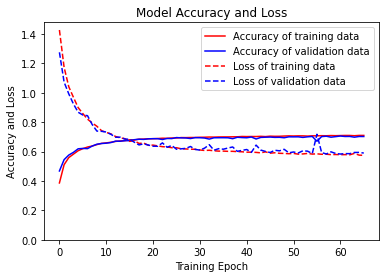

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

### F3-M3-64

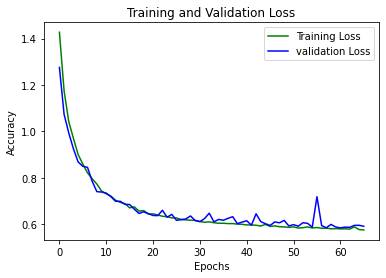

In [58]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0,66)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

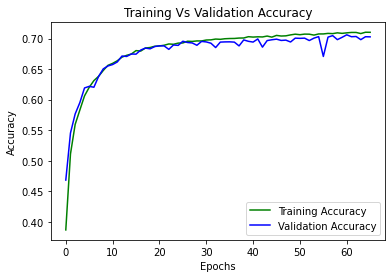

In [60]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(0,66)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
    

### F3-M4-64

In [64]:
model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
#model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))



model.add(GRU(units=50, return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
history=model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 7, 16)             64        
                                                                 
 conv1d_25 (Conv1D)          (None, 5, 64)             3136      
                                                                 
 conv1d_26 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 conv1d_27 (Conv1D)          (None, 1, 256)            98560     
                                                                 
 gru_13 (GRU)                (None, 1, 50)             46200     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 gru_14 (GRU)                (None, 1, 50)            

In [67]:
model.save('model-F3-M4-64')

# Save only the model weights
model.save_weights('model-F3-M4-64')

INFO:tensorflow:Assets written to: model-F3-M4-64\assets


INFO:tensorflow:Assets written to: model-F3-M4-64\assets


In [68]:
y_predict=model5.predict(x_test_t)
final=[]
for i in y_predict:
    max_index=np.argmax(i)
    binary_output=np.zeros_like(i)
    binary_output[max_index]=1
    final.append(binary_output)
    
final_test = []

# iterate over the list and find the index of elements with value 1
for my_list in test_labels:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_test.append(i)
            
final_predict = []

# iterate over the list and find the index of elements with value 1
for my_list in final:
    for i in range(len(my_list)):
        if my_list[i] == 1:
            final_predict.append(i)

2235/2235 [==============================] - 96s 43ms/step


[[ 1727  1010    36  2867    48     1  4603]
 [  921  1064   101  4335   151     1  3673]
 [    0     0     0 10167     0     0     0]
 [  942  1018   113  4376   201     0  3692]
 [  522  1243     3  5361   260     2  2747]
 [ 1469   628     5  3131     3     0  4807]
 [ 1550   971    44  3359    95     0  4270]]


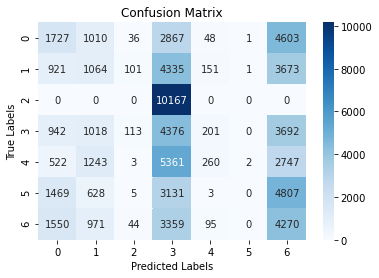

              precision    recall  f1-score   support

           0       0.24      0.17      0.20     10292
           1       0.18      0.10      0.13     10246
           2       0.00      0.00      0.00     10167
           3       0.13      0.42      0.20     10342
           4       0.34      0.03      0.05     10138
           5       0.00      0.00      0.00     10043
           6       0.18      0.42      0.25     10289

    accuracy                           0.16     71517
   macro avg       0.15      0.16      0.12     71517
weighted avg       0.15      0.16      0.12     71517



In [69]:
from sklearn.metrics import confusion_matrix



# create confusion matrix
cm = confusion_matrix(final_test,final_predict)

# print confusion matrix
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(final_test), yticklabels=np.unique(final_test))

# add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()
from sklearn.metrics import classification_report
print(classification_report(final_test,final_predict))
   

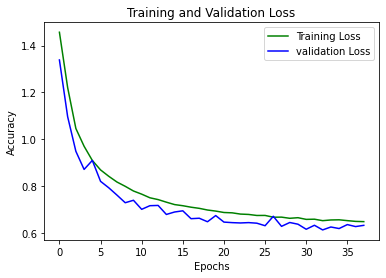

In [72]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0,38)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

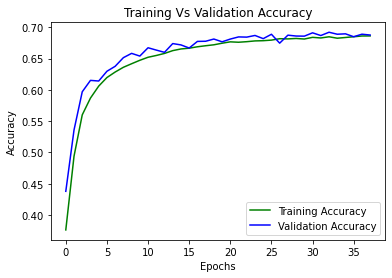

In [73]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(0,38)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
    

### F3-M1-64

In [ ]:
model = Sequential()

# Add the 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_t.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add the GRU layers
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))

# Add the output layer
model.add(Dense(train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# Train the model
model.fit(x_train_t,train_labels, batch_size=64, epochs=75, validation_data=(x_test_t,test_labels),callbacks=[es])
